This notebook is an exploratotion of the Titanic competition on Kaggle.
I got a score of 0.76794, which is not too bad.

In this I just plugged in a neural network with RELU activation in the hidden
layers and tuned the hyperparameters.

For better results, XGBoost is apparently a better choice. Should probably try that.

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV


2023-05-11 11:19:52.931878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Read in data from a CSV file using pandas
df = pd.read_csv('train.csv')

pred_df = pd.read_csv('test.csv')

# Split the data into training and testing sets using train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)

#train_df = pd.read_csv('train.csv')
#test_df = pd.read_csv('test.csv')

In [40]:
# Find NaN values in all columns of the training dataframe
print('NaN values in the training dataframe:')
print(train_df.isna().sum())

# Find NaN values in all columns of the testing dataframe
print('NaN values in the testing dataframe:')
print(test_df.isna().sum())

# Find NaN values in all columns of the testing dataframe
print('NaN values in the pred dataframe:')
print(pred_df.isna().sum())


NaN values in the training dataframe:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            145
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          548
Embarked         2
dtype: int64
NaN values in the testing dataframe:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             32
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          139
Embarked         0
dtype: int64
NaN values in the pred dataframe:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
# Explore the correlations between the features.

train_df.corr() 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005581,-0.041638,0.038604,-0.064002,-0.017725,0.001080
Survived,-0.005581,1.000000,-0.345093,-0.091101,-0.038025,0.090788,0.257220
Pclass,-0.041638,-0.345093,1.000000,-0.345138,0.095309,0.023190,-0.534687
Age,0.038604,-0.091101,-0.345138,1.000000,-0.331075,-0.189649,0.079569
SibSp,-0.064002,-0.038025,0.095309,-0.331075,1.000000,0.442913,0.153785
Parch,-0.017725,0.090788,0.023190,-0.189649,0.442913,1.000000,0.216796
Fare,0.001080,0.257220,-0.534687,0.079569,0.153785,0.216796,1.000000


Text(0, 0.5, 'Survival rate')

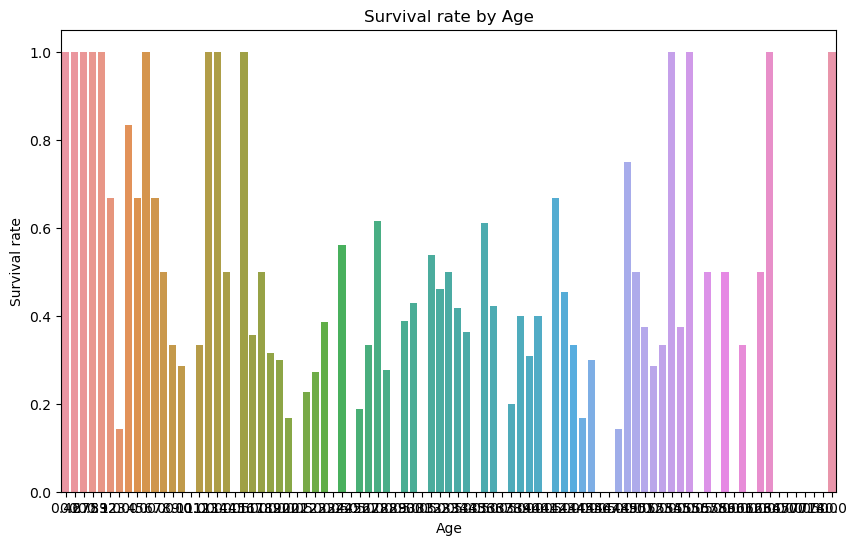

In [13]:
column = "Age"

grouped = train_df.groupby(column)['Survived'].mean().reset_index()
    # Create plot
plt.figure(figsize=(10,6))
sns.barplot(x=column, y='Survived', data=grouped)
plt.title(f"Survival rate by {column}")
plt.xlabel(column)
plt.ylabel("Survival rate")
    #plt.show()


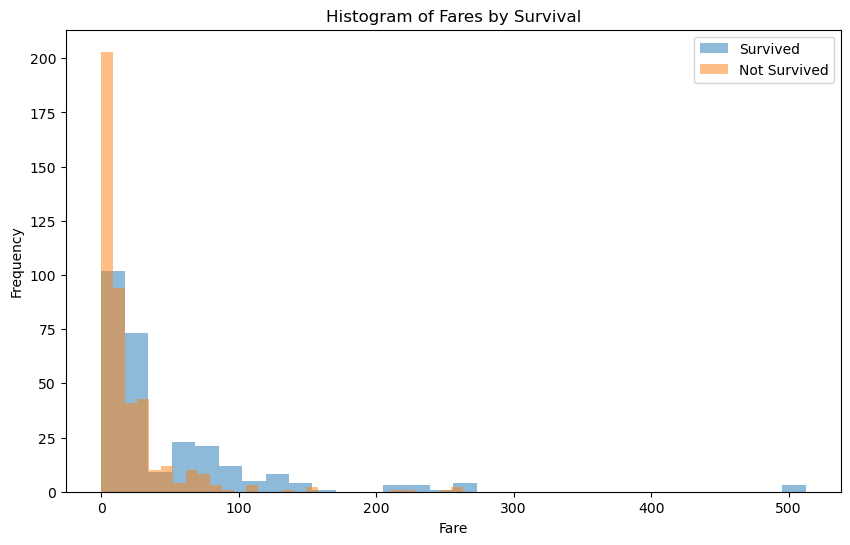

In [4]:
# Separate fares of passengers who survived and who did not survive
survived_fares = train_df[train_df['Survived'] == 1]['Fare']
not_survived_fares = train_df[train_df['Survived'] == 0]['Fare']

# Create the histogram
plt.figure(figsize=(10,6))
plt.hist(survived_fares, bins=30, alpha=0.5, label='Survived')
plt.hist(not_survived_fares, bins=30, alpha=0.5, label='Not Survived')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Fares by Survival')
plt.legend()
plt.show()


In [40]:
log_df = train_df.copy(deep=True)
#log_df.fillna(log_df['Age'].mean(), inplace=True)

In [12]:
#log_df['Fare'] = log_df['Fare'].replace(0, np.NaN)

(array([14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.

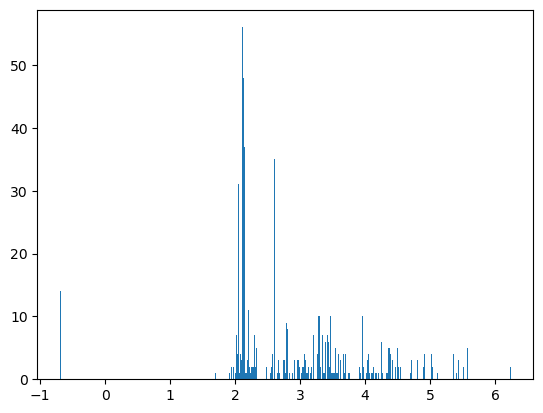

In [65]:
#log_df = fill_missing_with_regression(log_df, ['Pclass','Age','SibSp','Parch'], 'Fare')
#log_df['Fares_log'] = np.log(log_df['Fare'])
plt.hist(np.log(log_df['Fare'] + 0.5) , bins=560)

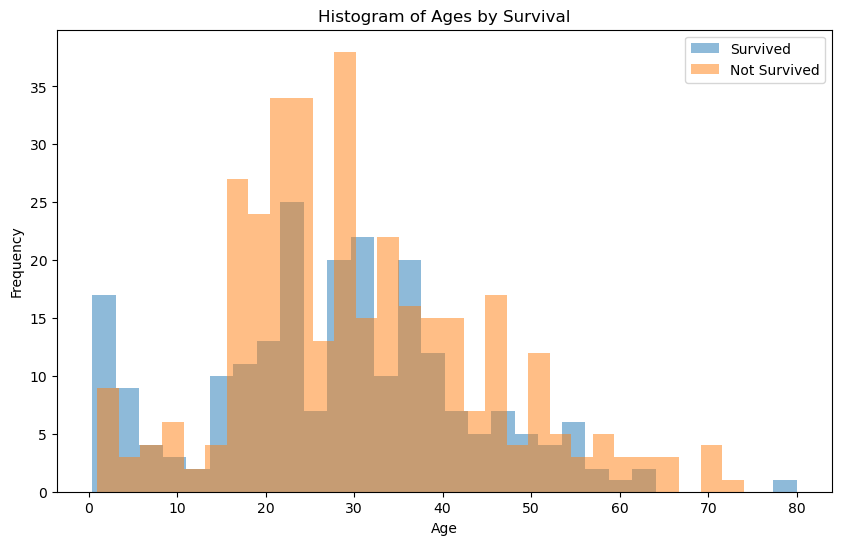

In [8]:
# Separate fares of passengers who survived and who did not survive
survived_fares = train_df[train_df['Survived'] == 1]['Age']
not_survived_fares = train_df[train_df['Survived'] == 0]['Age']

# Create the histogram
plt.figure(figsize=(10,6))
plt.hist(survived_fares, bins=30, alpha=0.5, label='Survived')
plt.hist(not_survived_fares, bins=30, alpha=0.5, label='Not Survived')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Ages by Survival')
plt.legend()
plt.show()


<Axes: xlabel='age_group'>

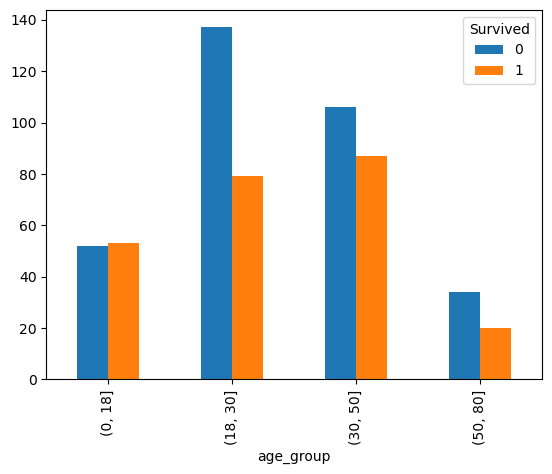

In [7]:
# Divide age into groups
train_df['age_group'] = pd.cut(train_df['Age'], bins=[0, 18, 30, 50, 80])

# Count the number of survivors and non-survivors in each age group
age_survived = train_df.groupby(['age_group', 'Survived'])['PassengerId'].count().unstack()

# Plot a stacked bar plot of the counts
age_survived.plot(kind='bar', stacked=False)


[ 0.42       11.78857143 23.15714286 34.52571429 45.89428571 57.26285714
 68.63142857 80.        ]
['age_label_0', 'age_label_1', 'age_label_2', 'age_label_3', 'age_label_4', 'age_label_5', 'age_label_6']


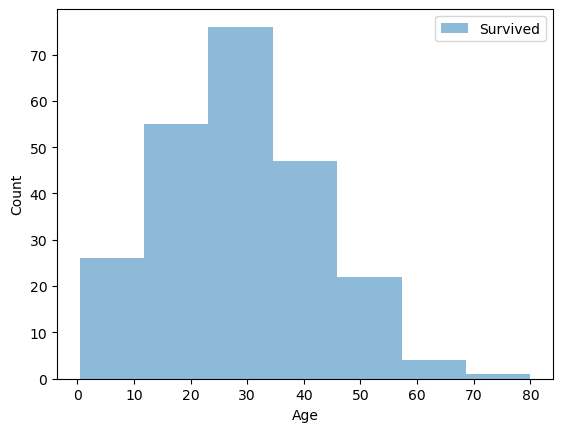

In [6]:

# Separate the ages for the survivors and non-survivors
survived_age = train_df[train_df['Survived']==1]['Age']
not_survived_age = train_df[train_df['Survived']==0]['Age']

# Create histogram with two groups, specifying bins and alpha values
n, bin_edges_age, patches = plt.hist(survived_age, bins=7, alpha=0.5, label='Survived')
#plt.hist(not_survived_age, bins=15, alpha=0.5, label='Not Survived')

print(bin_edges_age)

bin_edges_age_labels = [f'age_label_{i}' for i in range(len(bin_edges_age)-1)]
print(bin_edges_age_labels)

# Add labels and legend
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(loc='upper right')

# Show the plot
plt.show()


In [6]:
len(bin_edges_age)

8

[  0.   52.6 105.2 157.8 210.4 263. ]
<class 'numpy.ndarray'>


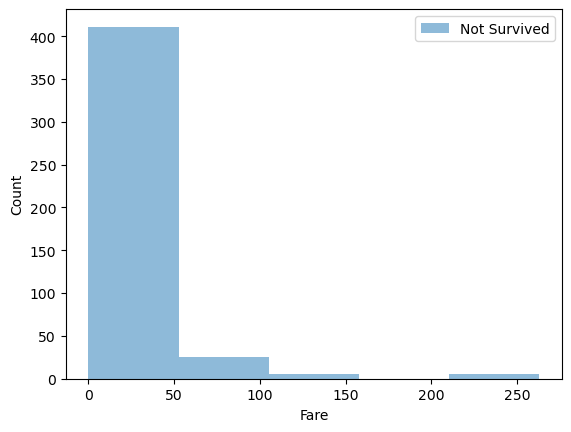

In [7]:
# explore bins for fare variable

# Separate the ages for the survivors and non-survivors
survived_fare = train_df[train_df['Survived']==1]['Fare']
not_survived_fare = train_df[train_df['Survived']==0]['Fare']

# Create histogram with two groups, specifying bins and alpha values
#plt.hist(survived_fare, bins=24, alpha=0.5, label='Survived')
n, bin_edges_fare, patches = plt.hist(not_survived_fare, bins=5, alpha=0.5, label='Not Survived')

bin_edges_fare_labels = [f'fare_label_{i}' for i in range(len(bin_edges_fare)-1)]

# Print the bin edges
print(bin_edges_fare)
print(type(bin_edges_fare))
# Add labels and legend
plt.xlabel('Fare')
plt.ylabel('Count')
plt.legend(loc='upper right')

# Show the plot
plt.show()


In [9]:
def fill_missing_with_regression(df, reg_cols, target_col):
    # split data into rows with and without missing target values
    missing = df[df[target_col].isna()]
    not_missing = df[~df[target_col].isna()]

    # fit linear regression model to non-missing data
    lr = LinearRegression()
    lr.fit(not_missing[reg_cols], not_missing[target_col])

    # predict target for missing data
    missing[target_col] = lr.predict(missing[reg_cols])

    # merge data back together
    df = pd.concat([missing, not_missing])

    # sort by PassengerId
    df = df.sort_values(by=['PassengerId'])
    
    return df


In [32]:
def perform_transformations(dataset):
    dataset['Fare'].fillna(dataset['Fare'].mean(), inplace=True)
    
    # Create a new categorical variable based on age, binned into 15 categories
    dataset['Age_Category'] = pd.cut(dataset['Age'], bins=bin_edges_age, labels=bin_edges_age_labels, include_lowest=True)
        
    #dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
    
    dataset['Fare_Category'] = pd.cut(dataset['Fare'], bins=bin_edges_fare, labels=bin_edges_fare_labels, include_lowest=True)

    
    dataset = pd.get_dummies(dataset, columns=['Sex'])
    dataset = pd.get_dummies(dataset, columns=['Embarked'])
    dataset = pd.get_dummies(dataset, columns=['Age_Category'])
    dataset = pd.get_dummies(dataset, columns=['Fare_Category'])

    #dataset['Cabin'] = dataset['Cabin'].apply(lambda x: 0 if pd.isna(x) else (2 if x[0] == 'B' or x[0] == 'C' else 1))
    # Define a dictionary to map cabin letters to numbers
    cabin_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

    # Apply the mapping to the 'Cabin' column in the 'dataset' data frame
    dataset['Cabin'] = dataset['Cabin'].str[0].map(cabin_mapping)
    dataset['Cabin'] = dataset['Cabin'].astype(float)
    dataset = fill_missing_with_regression(dataset, ['Pclass', 'SibSp', 'Parch', 'Fare'], 'Age')
    dataset = fill_missing_with_regression(dataset, ['Pclass', 'Age', 'Fare'], 'Cabin')
    
    dataset.drop(['Name', 'Ticket', 'Age', 'Fare'], axis=1, inplace=True)
    #print(dataset.head())
    return dataset.astype(float)

In [33]:
train_df = perform_transformations(train_df)
test_df = perform_transformations(test_df)
pred_df = perform_transformations(pred_df)
train_df.drop(['PassengerId'], axis=1, inplace=True)
test_df.drop(['PassengerId'], axis=1, inplace=True)


/var/folders/cb/p11211352wv37xf0h3t_mh9c0000gn/T/ipykernel_56528/1034814493.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing[target_col] = lr.predict(missing[reg_cols])
/var/folders/cb/p11211352wv37xf0h3t_mh9c0000gn/T/ipykernel_56528/1034814493.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing[target_col] = lr.predict(missing[reg_cols])
/var/folders/cb/p11211352wv37xf0h3t_mh9c0000gn/T/ipykernel_56528/1034814493.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [17]:
train_df.dtypes

Survived                      float64
Pclass                        float64
SibSp                         float64
Parch                         float64
Cabin                         float64
Sex_female                    float64
Sex_male                      float64
Embarked_C                    float64
Embarked_Q                    float64
Embarked_S                    float64
Age_Category_age_label_0      float64
Age_Category_age_label_1      float64
Age_Category_age_label_2      float64
Age_Category_age_label_3      float64
Age_Category_age_label_4      float64
Age_Category_age_label_5      float64
Age_Category_age_label_6      float64
Fare_Category_fare_label_0    float64
Fare_Category_fare_label_1    float64
Fare_Category_fare_label_2    float64
Fare_Category_fare_label_3    float64
Fare_Category_fare_label_4    float64
dtype: object

In [17]:
train_df.columns

Index(['Survived', 'Pclass', 'SibSp', 'Parch', 'Cabin', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Age_Category_age_label_0', 'Age_Category_age_label_1',
       'Age_Category_age_label_2', 'Age_Category_age_label_3',
       'Age_Category_age_label_4', 'Age_Category_age_label_5',
       'Age_Category_age_label_6', 'Age_Category_age_label_7',
       'Age_Category_age_label_8', 'Age_Category_age_label_9',
       'Age_Category_age_label_10', 'Age_Category_age_label_11',
       'Age_Category_age_label_12', 'Age_Category_age_label_13',
       'Age_Category_age_label_14', 'Fare_Category_fare_label_0',
       'Fare_Category_fare_label_1', 'Fare_Category_fare_label_2',
       'Fare_Category_fare_label_3', 'Fare_Category_fare_label_4',
       'Fare_Category_fare_label_5', 'Fare_Category_fare_label_6',
       'Fare_Category_fare_label_7', 'Fare_Category_fare_label_8',
       'Fare_Category_fare_label_9', 'Fare_Category_fare_label_10',
       'Fare_Category_

In [140]:
pred_df.columns

Index(['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Cabin', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Age_Category_age_label_0', 'Age_Category_age_label_1',
       'Age_Category_age_label_2', 'Age_Category_age_label_3',
       'Age_Category_age_label_4', 'Age_Category_age_label_5',
       'Age_Category_age_label_6', 'Age_Category_age_label_7',
       'Age_Category_age_label_8', 'Age_Category_age_label_9',
       'Age_Category_age_label_10', 'Age_Category_age_label_11',
       'Age_Category_age_label_12', 'Age_Category_age_label_13',
       'Age_Category_age_label_14', 'Fare_Category_fare_label_0',
       'Fare_Category_fare_label_1', 'Fare_Category_fare_label_2',
       'Fare_Category_fare_label_3', 'Fare_Category_fare_label_4',
       'Fare_Category_fare_label_5', 'Fare_Category_fare_label_6',
       'Fare_Category_fare_label_7', 'Fare_Category_fare_label_8',
       'Fare_Category_fare_label_9', 'Fare_Category_fare_label_10',
       'Fare_Catego

In [81]:
# Create a MinMaxScaler object
#scaler = MinMaxScaler()

# Normalize all columns in the training dataframe
#train_df[train_df.columns] = scaler.fit_transform(train_df[train_df.columns])

# Normalize all columns in the testing dataframe
#test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

#pred_df[pred_df.columns] = scaler.transform(pred_df[pred_df.columns])



In [34]:

# Define the input shape of your neural network
input_shape = train_df.shape[1] - 1

# Define the number of output neurons in your neural network
output_neurons = 1

In [35]:
train_df.columns

Index(['Survived', 'Pclass', 'SibSp', 'Parch', 'Cabin', 'Fares_squared',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Age_Category_age_label_0', 'Age_Category_age_label_1',
       'Age_Category_age_label_2', 'Age_Category_age_label_3',
       'Age_Category_age_label_4', 'Age_Category_age_label_5',
       'Age_Category_age_label_6', 'Fare_Category_fare_label_0',
       'Fare_Category_fare_label_1', 'Fare_Category_fare_label_2',
       'Fare_Category_fare_label_3', 'Fare_Category_fare_label_4'],
      dtype='object')

In [38]:
# Define the function to build the model with the given hyperparameters
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(
        units=hp.Choice('units_layer1', [10,20,50, 76, 128]), activation='relu'))
    model.add(layers.Dropout(hp.Choice('dropout_rate1', [0.1, 0.3, 0.5])))
    model.add(layers.Dense(
        units=hp.Choice('units_layer2', [10,20,50, 76, 128]), activation='relu'))
    model.add(layers.Dropout(hp.Choice('dropout_rate2', [0.1, 0.3, 0.5])))
    model.add(layers.Dense(
        units=hp.Choice('units_layer3', [4,8,16,32]), activation='relu'))
    model.add(layers.Dropout(hp.Choice('dropout_rate3', [0.1, 0.3, 0.5])))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    lr = hp.Choice('learning_rate', [0.001, 0.01, 0.1])
    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

# Define the tuner and run the search for the best hyperparameters
tuner = RandomSearch(
    build_model,
    objective='binary_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='titanic'
)

tuner.search(train_df.drop('Survived', axis=1), train_df['Survived'], 
             epochs=50, batch_size=64, validation_split=0.2)

# Print the summary of the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("The best hyperparameters are:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")


Trial 10 Complete [00h 00m 02s]
binary_accuracy: 0.6028119325637817

Best binary_accuracy So Far: 0.6028119325637817
Total elapsed time: 00h 00m 17s
INFO:tensorflow:Oracle triggered exit
The best hyperparameters are:
units_layer1: 128
dropout_rate1: 0.5
units_layer2: 10
dropout_rate2: 0.3
units_layer3: 4
dropout_rate3: 0.5
optimizer: sgd
learning_rate: 0.01


In [39]:
# Define the number of neurons in each hidden layer
hidden_layer_1_neurons = 128
hidden_layer_2_neurons = 10
hidden_layer_3_neurons = 4

# Define your neural network using the Sequential model in TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_1_neurons, activation='relu', input_shape=(input_shape,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(hidden_layer_2_neurons, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(hidden_layer_3_neurons, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(output_neurons, activation='sigmoid')
])
optimizer = keras.optimizers.SGD(learning_rate=0.01)
# Compile your neural network using binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

In [17]:
# Train your neural network using the training data
model.fit(train_df.drop('Survived', axis=1), train_df['Survived'], epochs=100, batch_size=64)

Epoch 1/100
12/12 [==============================] - 0s 714us/step - loss: nan - binary_accuracy: 0.6278
Epoch 2/100
12/12 [==============================] - 0s 721us/step - loss: nan - binary_accuracy: 0.6264
Epoch 3/100
12/12 [==============================] - 0s 803us/step - loss: nan - binary_accuracy: 0.6264
Epoch 4/100
12/12 [==============================] - 0s 698us/step - loss: nan - binary_accuracy: 0.6264
Epoch 5/100
12/12 [==============================] - 0s 624us/step - loss: nan - binary_accuracy: 0.6264
Epoch 6/100
12/12 [==============================] - 0s 709us/step - loss: nan - binary_accuracy: 0.6264
Epoch 7/100
12/12 [==============================] - 0s 692us/step - loss: nan - binary_accuracy: 0.6264
Epoch 8/100
12/12 [==============================] - 0s 642us/step - loss: nan - binary_accuracy: 0.6264
Epoch 9/100
12/12 [==============================] - 0s 671us/step - loss: nan - binary_accuracy: 0.6264
Epoch 10/100
12/12 [==============================] - 0

In [18]:
# Evaluate your neural network using the testing data
loss, accuracy = model.evaluate(test_df.drop('Survived', axis=1), test_df['Survived'])

# Print the accuracy of your neural network on the testing data
print('Accuracy:', accuracy)

ValueError: in user code:

    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/engine/training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/engine/training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/engine/training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/engine/training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 22), found shape=(None, 21)


In [126]:
predictions_test = model.predict(test_df.drop('Survived', axis=1))

6/6 [==============================] - 0s 574us/step


In [1]:
predictions_test = np.where(predictions_test < 0.5, 0, 1)

tn, fp, fn, tp = confusion_matrix(test_df['Survived'], predictions_test).ravel()

print("\nTest Set Confusion Matrix:")
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)
print("True Positive:", tp)

precision = tp / (tp + fp)
recall = tp / (tp + fn)

conf_acc = (tn + tp) / (tn + fp + fn + tp)

print("Accuracy:", conf_acc)
print("Precision:", precision)
print("Recall (specifisity):", recall)



NameError: name 'np' is not defined

In [40]:
# Merge and train on the entire dataset

entire_df = pd.concat([train_df, test_df], ignore_index=True)


In [ ]:
model.fit(entire_df.drop('Survived', axis=1), entire_df['Survived'], epochs=100, batch_size=64)

Epoch 1/100
14/14 [==============================] - 0s 747us/step - loss: nan - binary_accuracy: 0.6162
Epoch 2/100
14/14 [==============================] - 0s 711us/step - loss: nan - binary_accuracy: 0.6162
Epoch 3/100
14/14 [==============================] - 0s 671us/step - loss: nan - binary_accuracy: 0.6162
Epoch 4/100
14/14 [==============================] - 0s 644us/step - loss: nan - binary_accuracy: 0.6162
Epoch 5/100
14/14 [==============================] - 0s 671us/step - loss: nan - binary_accuracy: 0.6162
Epoch 6/100
14/14 [==============================] - 0s 596us/step - loss: nan - binary_accuracy: 0.6162
Epoch 7/100
14/14 [==============================] - 0s 615us/step - loss: nan - binary_accuracy: 0.6162
Epoch 8/100
14/14 [==============================] - 0s 584us/step - loss: nan - binary_accuracy: 0.6162
Epoch 9/100
14/14 [==============================] - 0s 628us/step - loss: nan - binary_accuracy: 0.6162
Epoch 10/100
14/14 [==============================] - 0

In [19]:
pred_df.columns

Index(['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Cabin', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Age_Category_age_label_0', 'Age_Category_age_label_1',
       'Age_Category_age_label_2', 'Age_Category_age_label_3',
       'Age_Category_age_label_4', 'Age_Category_age_label_5',
       'Age_Category_age_label_6', 'Fare_Category_fare_label_0',
       'Fare_Category_fare_label_1', 'Fare_Category_fare_label_2',
       'Fare_Category_fare_label_3', 'Fare_Category_fare_label_4'],
      dtype='object')

In [24]:
entire_df.columns


Index(['Survived', 'Pclass', 'SibSp', 'Parch', 'Cabin', 'Fares_squared',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Age_Category_age_label_0', 'Age_Category_age_label_1',
       'Age_Category_age_label_2', 'Age_Category_age_label_3',
       'Age_Category_age_label_4', 'Age_Category_age_label_5',
       'Age_Category_age_label_6', 'Fare_Category_fare_label_0',
       'Fare_Category_fare_label_1', 'Fare_Category_fare_label_2',
       'Fare_Category_fare_label_3', 'Fare_Category_fare_label_4'],
      dtype='object')

In [21]:
predictions = model.predict(pred_df.drop('PassengerId', axis=1))

ValueError: in user code:

    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/espen/opt/anaconda3/envs/IBM/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 22), found shape=(None, 21)


In [27]:
predictions = np.where(predictions < 0.5, 0, 1)


In [28]:
predictions_n = predictions.reshape(418,)
predictions_n.shape
predictions_n = predictions_n.astype(int)

In [25]:
pred_df['PassengerId'].shape

(418,)

In [30]:
pred_df['PassengerId'] = pred_df['PassengerId'].astype(int)


In [31]:
output_df = pd.DataFrame({'PassengerId': pred_df['PassengerId'], 'Survived': predictions_n})

In [32]:
output_df.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
